<a href="https://colab.research.google.com/github/DT2024/Fashinion_MNIST_Classification/blob/main/Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

In [ ]:
#Check the availabilty of GPU
torch.cuda.is_available()

True

In [ ]:
#Use GPU as a device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
#Importing the Fashion MNIST Dataset
import torchvision
import torchvision.transforms as transforms


# Load the dataset
dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)

print(dataset.data.shape)
print(dataset.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [ ]:
# After Loading the dataset, I need to change to numpy array and extract only 10000
X=dataset.data.numpy()
y=dataset.targets.numpy()

X=X[:10000]
y=y[:10000]



In [ ]:
X.shape

(10000, 28, 28)

In [ ]:
y.shape

(10000,)

In [ ]:
#Before moving on and doing 4 steps I need to normalize the image and convert to pytorch type
X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(1) / 255.0  # Normalize & and this unsqueeze(1) had to used when it is CNN or using Resize() apparently
y_t = torch.tensor(y, dtype=torch.long)


In [ ]:
#Then I need to resize to images 64X64, at first I tried how it was explained in the class dataloader but it didn't work for me
# So I have to resize then use that resized data to the dataloader
resize_transform = transforms.Resize((64, 64))
X_t_resized = torch.stack([resize_transform(img) for img in X_t])   #I have to do this to apply the resized size to X

In [ ]:
#Now I can do other steps of 4 important steps to use in pytorch
# Step 2: Perform Train Test Split and Normalize the data
train_data, test_data, train_labels, test_labels = train_test_split(X_t_resized, y_t, test_size = 0.1)

train_data = train_data/torch.max(train_data)
test_data  = test_data/torch.max(test_data)


# Step 3: Convert into PyTorch Datasets
X_train = TensorDataset(train_data,train_labels)
X_test  = TensorDataset(test_data,test_labels)


# Step 4: Move the data into dataloader objects
batchsize    = 32
train_loader = DataLoader(X_train, batch_size = batchsize, shuffle = True, drop_last=True)
test_loader  = DataLoader(X_test, batch_size = X_test.tensors[0].shape[0])

In [ ]:
#The result here need to confirm that the size of the images are now 64X64
for X,y in train_loader:
    break
X.shape

torch.Size([32, 1, 64, 64])

In [ ]:
#How many classes this dataset have?
number_classes=len(set(dataset.targets.numpy()))
number_classes

10

In [ ]:
#Creating neural network and since in the class example it was 28X28 and 784, then in 1X64X64 it should be 4096
class NN_Classifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(4096,64)
    self.fc1 = nn.Linear(64,32)
    self.fc2 = nn.Linear(32,32)

    # Classification OR  output layer

    self.output = nn.Linear(32,10)

  # Forward pass

  def forward(self,x):

    # Pass the data through the input layer
    x = x.view(x.shape[0], -1)  # Ensure correct shape
    x = self.input(x)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)

    # output layer

    x = self.output(x)
    # X = torch.sigmoid
    return x

In [ ]:
model = NN_Classifier()

In [ ]:
model

NN_Classifier(
  (input): Linear(in_features=4096, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
#Train and Test Model
epochs = 101

lossfunc = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), momentum = 0.9, lr = 0.01)

model.to(device) # placing a model on GPU

# Initialize losses and Accuracies

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


# For Loop for epochs

for epoch in range(epochs):
 model.train()

 # Loop for training in batches

 batchAcc  = []
 batchLoss = []

 for X,y in train_loader:

  X = X.to(device) # Placing features on device
  y = y.to(device) # placing labels on device

  ypred = model(X)
  loss = lossfunc(ypred,y)

# Backpropagation

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Append batchloss

  batchLoss.append(loss.item())

  ypred = ypred.cpu() # Back to cpu
  y = y.cpu()

  # compute batch accuracy

  acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
  batchAcc.append(acc)

# Batch loop concluded

# Average training accuracy (Outside the batchloop)

 trainAcc.append(np.mean(batchAcc))

# Losses through epochs

 losses[epoch] = np.mean(batchLoss)

# TESTING the model

 model.eval()
 X,y = next(iter(test_loader))
 X = X.to(device)
 y = y.to(device)

 with torch.no_grad(): #This step  Deactivating autogradient
  ypred = model(X)
  ypred = ypred.cpu()
  y = y.cpu()

 # Appending test accuracy

  testAcc.append(100 * torch.mean((torch.argmax(ypred,dim=1)==y).float()))
  if (epoch % 10) == 0:

        print(f' epochs : {epoch}  loss : {loss : 2.2f}')



 epochs : 0  loss :  0.88
 epochs : 10  loss :  0.17
 epochs : 20  loss :  0.49
 epochs : 30  loss :  0.21
 epochs : 40  loss :  0.35
 epochs : 50  loss :  0.16
 epochs : 60  loss :  0.24
 epochs : 70  loss :  0.13
 epochs : 80  loss :  0.11
 epochs : 90  loss :  0.05
 epochs : 100  loss :  0.08


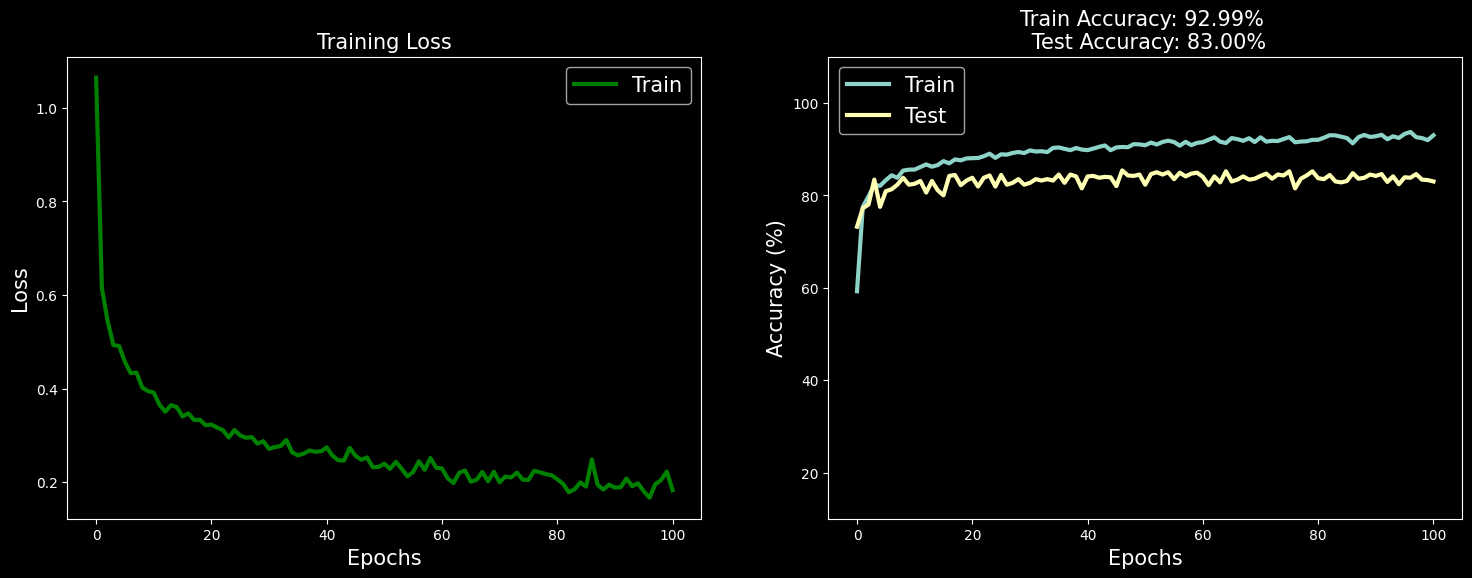

In [ ]:
#Visualising the loss and accuracies

fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

In [ ]:
ypred = np.argmax(ypred, axis = 1)

In [ ]:
#print Classification report
from sklearn.metrics import classification_report
print(classification_report(y, ypred))

              precision    recall  f1-score   support

           0       0.72      0.90      0.80        96
           1       0.97      0.98      0.97        97
           2       0.64      0.80      0.71       105
           3       0.87      0.84      0.86        96
           4       0.68      0.72      0.70        90
           5       0.99      0.90      0.94        93
           6       0.69      0.36      0.47       107
           7       0.87      0.93      0.90       107
           8       0.96      0.95      0.96       106
           9       0.93      0.94      0.94       103

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.82      1000
weighted avg       0.83      0.83      0.82      1000

